# IMPORTS

In [1]:
import os
import numpy as np
import pandas as pd
# from Agent import Agent
import matplotlib.pyplot as plt
import warnings
import grid2op
from grid2op.Action import TopologyChangeAction
from tqdm.notebook import tqdm
import grid2op
# from utils import obs_to_vect, Converter, plotLearning

e:\L2RPN\L2RPN_delft2023_starting_kit_1\L2RPN_delft2023_starting_kit\l2rpn\Lib\site-packages\grid2op\Backend\pandaPowerBackend.py:36: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	e:\L2RPN\L2RPN_delft2023_starting_kit_1\L2RPN_delft2023_starting_kit\l2rpn\Scripts\python.exe -m pip install numba

  warnings.warn(


In [2]:
import re
# import agent_emil as agent 

In [3]:
from grid2op.Chronics import GridStateFromFileWithForecasts
from grid2op.Agent import DoNothingAgent,RandomAgent,PowerLineSwitch,AgentWithConverter
from grid2op.Action import DontAct,PowerlineChangeAction,TopologySetAction,TopologyChangeAction
from grid2op.PlotGrid import PlotMatplot
from grid2op.Parameters import Parameters
from grid2op.Converter import IdToAct,Converter
from grid2op.Reward import FlatReward

In [4]:
from itertools import product
from tqdm.notebook import tqdm 

# CREATE ENVIROMENT

In [5]:
p = Parameters()
# Disable lines disconnections due to overflows
# p.NO_OVERFLOW_DISCONNECTION = False  # disconnect powerlines above their limits for too long or for “too much”
# Allow many steps with overflow
# p.NB_TIMESTEP_OVERFLOW_ALLOWED = 1 # Default is 2
# No waiting time to reconnect
# p.NB_TIMESTEP_RECONNECTION = 0
# No authomatic disconnection
# p.HARD_OVERFLOW_THRESHOLD = 9999

In [6]:
env_name = "rte_case14_realistic"
env = grid2op.make(env_name, test=True, action_class=TopologyChangeAction)
# For reproducibility
env.seed(0)

e:\L2RPN\L2RPN_delft2023_starting_kit_1\L2RPN_delft2023_starting_kit\l2rpn\Lib\site-packages\grid2op\MakeEnv\Make.py:454: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


(array(0),
 (209652396, 2087557356),
 (398764591,),
 (924231285,),
 (1478610112,),
 ((441365315,), (633163265,)),
 (1537364731,))

In [7]:
CHRONIC_ID = 000
episode_count = 100 

In [8]:
print(f'No of Substations: {env.n_sub} ')
print(f'No of Generators: {env.n_gen} ')
print(f'No of Loads: {env.n_load} ')
print(f'No of Lines: {env.n_line} ')
print(f'No of Busbar per Substation: {env.n_busbar_per_sub} ')

No of Substations: 14 
No of Generators: 5 
No of Loads: 11 
No of Lines: 20 
No of Busbar per Substation: 2 


In [9]:
# Print details for each substation
for sub_id in range(env.n_sub):
    print(f"Substation {sub_id} details:")
    print(env.sub_info[sub_id])

Substation 0 details:
3
Substation 1 details:
6
Substation 2 details:
4
Substation 3 details:
6
Substation 4 details:
5
Substation 5 details:
6
Substation 6 details:
3
Substation 7 details:
2
Substation 8 details:
5
Substation 9 details:
3
Substation 10 details:
3
Substation 11 details:
3
Substation 12 details:
4
Substation 13 details:
3


In [10]:
def get_total_bus_actions(env):
    total_actions = 0

    # Assume there are 2 buses per substation
    n_buses = 2

    # Iterate over each substation
    for sub_id in range(env.n_sub):
        n_elements = env.sub_info[sub_id]  # Number of elements in the substation
        
        # Each element can switch to the other bus, which gives n_buses - 1 actions per element
        total_actions += n_elements * (n_buses - 1)
    
    return total_actions

# Calculate the total bus actions
total_bus_actions = get_total_bus_actions(env)
print(f"Total number of bus actions: {total_bus_actions}")


Total number of bus actions: 56



# CONVERT GRID2OP ACTION TO ONE HOT ENCODING ACTION

In [11]:
n_powerlines = 20
n_substations = 14
total_bus_actions = 56


In [12]:
def create_one_hot_converter(n_powerlines,n_substations,total_bus_actions):
    """
    Creates two 2-d np.arrays used for conversion between grid2op action to one hot encoding action vector used by a neural network
    """    
    one_hot_encoding_act_conv = []
    env_act_dict_list = []
    zero_act = np.zeros((n_powerlines+total_bus_actions,1))
    # print(zero_act.shape)
    # print(zero_act)

    ## Add do nothing action vector (all zeroes)
    one_hot_encoding_act_conv.append(zero_act)
    env_act_dict_list.append({}) ## {} is the do nothing dictonary for actions in grid2op
    # print(env_act_dict_list)

    ## Powerline change actions
    for idx in range(n_powerlines):
        one_hot_encoding_act_conv_pwline = zero_act.copy()
        one_hot_encoding_act_conv_pwline[total_bus_actions+idx] = 1
        one_hot_encoding_act_conv.append(one_hot_encoding_act_conv_pwline)
        env_act_dict_list.append({'change_line_status': [idx]}) ## {'change_line_status': [idx]} set an action of changing line status for lineid with id idx
        # print(env_act_dict_list)

    ## Bus change actions
    start_slice = 0
    for sub_station_id, nb_el in enumerate(env.action_space.sub_info):
        one_hot_encoding_act_conv_substation = zero_act.copy()
        # print(f"Substation {sub_station_id} has {nb_el} elements")
        possible_bus_actions = np.array(list(product('01', repeat=nb_el))).astype(int)
        for possible_bus_action in possible_bus_actions:
            if possible_bus_action.sum()>0: # Do not include no change action vector
                one_hot_encoding_act_conv_substation[start_slice:(start_slice+nb_el)] = possible_bus_action.reshape(-1,1)
                one_hot_encoding_act_conv.append(one_hot_encoding_act_conv_substation.copy())
                env_act_dict_list.append({"change_bus": {"substations_id": [(sub_station_id, possible_bus_action.astype(bool))]}})
        start_slice += nb_el

    one_hot_encoding_act_conv = np.array(one_hot_encoding_act_conv).reshape(len(one_hot_encoding_act_conv),n_powerlines+total_bus_actions)

    return one_hot_encoding_act_conv,env_act_dict_list


def convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv,env_act):
    """
    Converts an grid2op action (in numpy format) to a one hot encoding vector
    """
    one_hot_encoding_act = np.zeros(len(one_hot_encoding_act_conv))
    env_act = env_act.reshape(-1,)
    action_idx = (one_hot_encoding_act_conv[:, None] == env_act).all(-1).any(-1)
    one_hot_encoding_act[action_idx] = 1
    return one_hot_encoding_act

def convert_one_hot_encoding_act_to_env_act(env_act_dict_list,one_hot_encoding_act,env=env):
    """
    Converts a one hot encoding action to a grid2op action
    """
    return env.action_space(env_act_dict_list[one_hot_encoding_act.argmax().item()])

# _,env_act_dict_list =  create_one_hot_converter(n_powerlines,n_substations,total_bus_actions)
# print(env_act_dict_list)

In [13]:
one_hot_encoding_act_conv,env_act_dict_list = create_one_hot_converter(n_powerlines,n_substations,total_bus_actions)

my_agent = RandomAgent(env.action_space)
all_obs = []
obs = env.reset()
reward = env.reward_range[0]
reward_list = []
done = False
nb_step = 0
action = my_agent.act(obs, reward, done)
#print(action.to_vect()[:56])
#print(action.to_vect()[-20:])
print("Action directly from grid2op")
print(action)
#print(action.to_dict())
tmp_ = convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv,env_act=action.to_vect())
my_action = convert_one_hot_encoding_act_to_env_act(env_act_dict_list,tmp_)
print("Action converted to one hot encoding and back to grid2op action. Should be the same as above")
print(my_action)

Action directly from grid2op
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element(s):
	 	 - Switch bus of line (extremity) id 5 [on substation 3]
	 	 - Switch bus of line (origin) id 15 [on substation 3]
	 	 - Switch bus of line (origin) id 16 [on substation 3]
	 - NOT force any particular bus configuration
Action converted to one hot encoding and back to grid2op action. Should be the same as above
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element(s):
	 	 - Switch bus of line (extremity) id 5 [on substation 3]
	 	 - Switch bus of line (origin) id 15

# DO NOTHING AGENT

In [14]:
env.chronics_handler.max_timestep()

8064

In [15]:
my_agent = DoNothingAgent(env.action_space)
all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
reward_list = []
done = False
nb_step = 0
print("Do Nothing Agent Simulation")
with tqdm(total=env.chronics_handler.max_timestep()) as pbar:

    # env.set_id(CHRONIC_ID)
    # ob = env.reset()

    while True:
        action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        reward_list.append(reward)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

reward_list_do_nothing_agent = np.copy(reward_list)
print(nb_step)

Do Nothing Agent Simulation


  0%|          | 0/8064 [00:00<?, ?it/s]

798


In [16]:
reward_list_do_nothing_agent

array([ 90.892365,  90.27503 ,  91.001724,  90.96513 ,  91.73933 ,
        91.627945,  93.29091 ,  93.87387 ,  94.738914,  94.6588  ,
        95.9449  ,  96.23099 ,  96.64119 ,  95.82291 ,  96.477394,
        96.72495 ,  97.22262 ,  96.805984,  96.84982 ,  96.68316 ,
        96.63987 ,  96.68316 ,  97.76865 ,  96.88922 ,  98.23717 ,
        98.880066,  98.02426 ,  98.66588 ,  97.85428 ,  98.83789 ,
        98.66634 ,  98.53629 ,  99.358765, 100.59496 , 100.01722 ,
       101.6807  , 101.86466 , 102.325615, 103.35393 , 103.25883 ,
       103.58879 , 103.87668 , 104.114296, 104.4023  , 105.082405,
       105.91757 , 106.06642 , 106.16507 , 107.17199 , 105.817665,
       107.73292 , 107.01946 , 107.68306 , 106.86703 , 107.52705 ,
       106.51374 , 107.32307 , 108.560005, 107.220894, 108.194756,
       108.76738 , 107.628265, 107.78295 , 108.610016, 107.73185 ,
       107.32281 , 107.833916, 106.71559 , 107.37363 , 108.14301 ,
       107.6291  , 106.96728 , 107.17028 , 107.11992 , 107.679

# RANDOM ACTION AGENT

In [17]:
my_agent = RandomAgent(env.action_space)
all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
reward_list = []
done = False
nb_step = 0
print("Random Agent Simulation")
with tqdm(total=env.chronics_handler.max_timestep()) as pbar:

    # env.set_id(CHRONIC_ID)
    # ob = env.reset()
    
    while True:
        action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        reward_list.append(reward)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

reward_list_random_agent = np.copy(reward_list)
print(nb_step)

Random Agent Simulation


  0%|          | 0/8064 [00:00<?, ?it/s]

3


# GRAPHICAL COMPARISON OF PRE-BUILT AGENTS

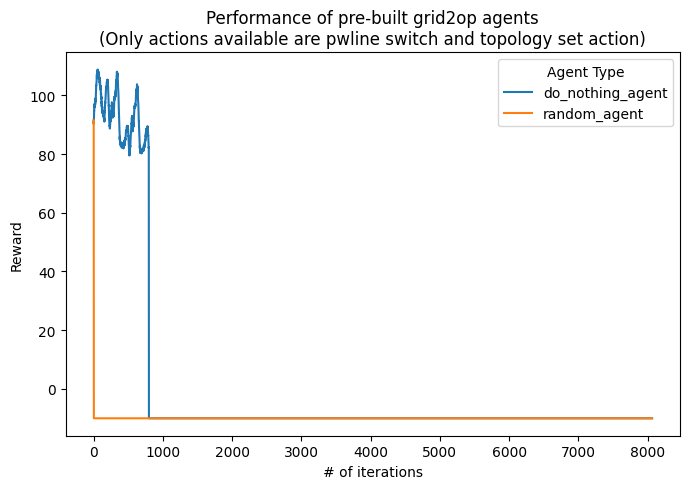

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

nested_lists = [reward_list_do_nothing_agent,reward_list_random_agent]
lists_to_df  = []

for nested_list in  nested_lists:
  len_list = len(nested_list)
  final_value = nested_list[-1]
  list_ = np.repeat(final_value,env.chronics_handler.max_timestep())
  list_[:len_list] = nested_list
  lists_to_df.append(list_)

df_pre_built_agents = pd.DataFrame(lists_to_df)\
.transpose()\
.rename(columns={0:'do_nothing_agent',1:'random_agent'})\
.stack()\
.reset_index()\
.rename(columns={'level_0':'iteration','level_1':'agent_type',0:'reward'})


fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.lineplot(x='iteration',y='reward',hue='agent_type',ax=ax,data=df_pre_built_agents)
ax.set_xlabel("# of iterations")
ax.set_ylabel("Reward")
ax.set_title("Performance of pre-built grid2op agents\n(Only actions available are pwline switch and topology set action)")
ax.legend(title='Agent Type')
plt.tight_layout()
plt.show()
# df_pre_built_agents = pd.DataFrame({'random_agent':reward_list_random_agent,
#                                     'power_line_switch_agent':reward_power_line_switch_agent
#                                     })
# df_pre_built_agents

# SIMPLE DQN

In [19]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#%% Agent

class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)
    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)
    




class DQN(nn.Module):
    """Deep Q-network with target network"""
    
    def __init__(self, NN_PARAMS):
        super(DQN, self).__init__()
        self.NN_PARAMS = NN_PARAMS
        self.hd_layers = nn.ModuleList()
        # network
        if NN_PARAMS['n_hidden_layers']==0:
            self.out = nn.Linear(NN_PARAMS['n_inputs'], NN_PARAMS['n_outputs'])
        else:
            self.out = nn.Linear(NN_PARAMS['n_hidden_units'][-1], NN_PARAMS['n_outputs'])
        
        if NN_PARAMS['n_hidden_layers']>0:
            input_units = NN_PARAMS['n_inputs']
            for i in range(NN_PARAMS['n_hidden_layers']):
                self.hd_layers.append(nn.Linear(input_units, NN_PARAMS['n_hidden_units'][i]))
                input_units = NN_PARAMS['n_hidden_units'][i]
                
        # training
        if NN_PARAMS['optimizer']=='SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=NN_PARAMS['learning_rate'])
        elif NN_PARAMS['optimizer']=='ADAM':
            self.optimizer = optim.Adam(self.parameters(), lr=NN_PARAMS['learning_rate'],weight_decay=NN_PARAMS['weight_decay'])
    
    def forward(self, x):
        if self.NN_PARAMS['n_hidden_layers']==0:
            return self.out(x)
        else:      
            for i in range(len(self.hd_layers)):
                x = F.relu(self.hd_layers[i](x))
            return self.out(x)           
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

    def print_NN_PARAMS(self):
        print(self.NN_PARAMS)


# NN_PARAMS = {
#     'n_inputs':100,
#     'n_outputs':100,
#     'n_hidden_layers':2,
#     'n_hidden_units':[300,300],
#     'relu':True,
#     'optimizer':'ADAM',
#     'learning_rate':0.005,
#     'weight_decay':0.001
# }
# policy_dqn = DQN(NN_PARAMS)
# x = torch.from_numpy(np.zeros(NN_PARAMS['n_inputs'])).float()
# policy_dqn(x)
# %%

In [20]:
load_qdn_from_network = False
prefix_NN_weight_files = 'dec_2_'

In [21]:
def act_vect_to_act_obj(env, Q_est):
    """
    This function returns a grid2op action object based on the estimated Q-value vector.
    It operates as follows:
    1. Identifies whether a' (action that maximizes Q function is positive).
    2. if a' is non-positive, do nothing action is returned
    3. if a' positive a grid2op action with line change of a' is returned.   

    Arguments:

    env: grid2op enviroment

    Q_est: torch array
    - Estimated Q-value function 

    Returns
    a: grid2op action object
    """

    ## Fix potential nan values
    Q_est[Q_est!=Q_est] = -1
    a_argmax = Q_est.argmax()

    # Check if a' is above zero
    if Q_est.max()>0:
        line_id = Q_est.argmax().item()
        a = env.action_space({'change_line_status': [line_id]}) # Change line status of line with line_id
    else:
        a = env.action_space({}) # Do nothing

    return a

In [22]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"

In [23]:
one_hot_encoding_act_conv,env_act_dict_list = create_one_hot_converter(n_powerlines,n_substations,total_bus_actions)

In [24]:
TRAINING_PARAMS = {
    'num_episodes':2500,
    'episode_limit':env.chronics_handler.max_timestep(),
    'batch_size':64,
    'replay_memory_capacity':20000,
    'prefil_memory':True,
    'val_freq':100,
    'tau':0.01,
    'gamma':0.99,
    'episilon_decay':'Linear' # 'Linear' or 'Exponential'
}

In [25]:
NN_PARAMS = {
    'n_inputs':env.observation_space.n,
    'n_outputs':len(one_hot_encoding_act_conv),
    'n_hidden_layers':3,
    'n_hidden_units':[300,300,300],
    'relu':True,
    'optimizer':'SGD',
    'learning_rate':0.005,
    'weight_decay':0.001
}

In [26]:
# n_inputs = env.observation_space.n
# n_outputs = env.action_space.n


In [27]:
policy_dqn = DQN(NN_PARAMS)
target_dqn = DQN(NN_PARAMS)


In [28]:
if load_qdn_from_network:
  target_dqn.load_state_dict(torch.load('checkpoint_target_dqn.pth'))
  policy_dqn.load_state_dict(torch.load('checkpoint_policy_dqn.pth'))

In [29]:
# set to cuda if available
policy_dqn = policy_dqn.to(dev)
target_dqn = target_dqn.to(dev)


In [30]:
replay_memory = ReplayMemory(TRAINING_PARAMS['replay_memory_capacity'])


In [31]:
# prefill replay memory with random actions
if TRAINING_PARAMS['prefil_memory']:
    print('prefill replay memory')
    s = env.reset()
    with tqdm(total=TRAINING_PARAMS['replay_memory_capacity']) as pbar:
      while replay_memory.count() < TRAINING_PARAMS['replay_memory_capacity']:
          a = env.action_space.sample()
          try:
            s1, r, d, _ = env.step(a)
          except Exception as e:
            print(f"An error occurred: {e}")
            print(f"Action: {a}")
            print(f"Current State: {s}")
          a_one_hot = convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv,env_act=a.to_vect())
          replay_memory.add(s.to_vect(), a_one_hot, r, s1.to_vect(), d)
          s = s1 if not d else env.reset()
          pbar.update(1)

prefill replay memory


  0%|          | 0/20000 [00:00<?, ?it/s]

An error occurred: failed to factorize matrix at line 110 in file ../scipy/sparse/linalg/_dsolve/SuperLU/SRC/dsnode_bmod.c

Action: This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - Switch status of 1 powerlines ([16])
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
Current State: <grid2op.Space.GridObjects.CompleteObservation_rte_case14_realistic object at 0x000001B68E4D6CF0>


In [33]:
def train_dqn(policy_dqn, target_dqn, replay_memory, env, TRAINING_PARAMS, one_hot_encoding_act_conv, env_act_dict_list, dev):
    epsilon = 1.0  # Exploration rate
    epsilon_min = 0.01
    epsilon_decay = 0.995  # Exponential decay

    for episode in range(TRAINING_PARAMS['num_episodes']):
        # Reset the environment for each new episode
        state = env.reset()
        total_reward = 0
        done = False

        # Loop over timesteps for each episode
        for timestep in range(TRAINING_PARAMS['episode_limit']):
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                # Take a random action
                action = env.action_space.sample()
                action_one_hot = convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv, action.to_vect())
            else:
                # Take action based on the policy network (exploitation)
                state_tensor = torch.FloatTensor(state.to_vect()).to(dev)
                q_values = policy_dqn(state_tensor)
                action = act_vect_to_act_obj(env, q_values.cpu().detach().numpy())
                action_one_hot = convert_env_act_to_one_hot_encoding_act(one_hot_encoding_act_conv, action.to_vect())

            # Interact with the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store the experience in replay memory
            replay_memory.add(state.to_vect(), action_one_hot, reward, next_state.to_vect(), done)

            # Sample from replay memory and train the network
            if replay_memory.count() > TRAINING_PARAMS['batch_size']:
                # Sample a batch of experiences from memory
                batch = replay_memory.sample(TRAINING_PARAMS['batch_size'])
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)

                # Convert to tensors
                states = torch.FloatTensor(np.array(batch_states)).to(dev)
                actions = torch.FloatTensor(np.array(batch_actions)).to(dev)
                rewards = torch.FloatTensor(np.array(batch_rewards)).to(dev)
                next_states = torch.FloatTensor(np.array(batch_next_states)).to(dev)
                dones = torch.FloatTensor(np.array(batch_dones)).to(dev)

                # Compute Q values using the policy network
                q_values = policy_dqn(states)
                q_values = torch.sum(q_values * actions, dim=1)  # Select action values

                # Compute target Q values using the target network
                with torch.no_grad():
                    next_q_values = target_dqn(next_states)
                    max_next_q_values = next_q_values.max(dim=1)[0]  # Max Q value for next state

                # Calculate the target
                targets = rewards + (1 - dones) * TRAINING_PARAMS['gamma'] * max_next_q_values

                # Compute loss
                loss = F.mse_loss(q_values, targets)

                # Optimize the policy network
                policy_dqn.optimizer.zero_grad()
                loss.backward()
                policy_dqn.optimizer.step()

                # Soft update the target network
                target_dqn.update_params(policy_dqn.state_dict(), TRAINING_PARAMS['tau'])

            # Move to the next state
            state = next_state

            # Break if the episode is finished
            if done:
                break

        # Decay epsilon for exploration-exploitation trade-off
        if epsilon > epsilon_min:
            if TRAINING_PARAMS['episilon_decay'] == 'Exponential':
                epsilon *= epsilon_decay
            elif TRAINING_PARAMS['episilon_decay'] == 'Linear':
                epsilon -= (1 - epsilon_min) / TRAINING_PARAMS['num_episodes']

        # Log progress every 100 episodes
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{TRAINING_PARAMS['num_episodes']}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    # Save the models
    torch.save(policy_dqn.state_dict(), 'checkpoint_policy_dqn.pth')
    torch.save(target_dqn.state_dict(), 'checkpoint_target_dqn.pth')
    print("Training complete! Models saved.")



In [34]:
train_dqn(policy_dqn, target_dqn, replay_memory, env, TRAINING_PARAMS, one_hot_encoding_act_conv, env_act_dict_list, dev)

Episode 100/2500, Total Reward: 262.10, Epsilon: 0.96
Episode 200/2500, Total Reward: 171.07, Epsilon: 0.92
Episode 300/2500, Total Reward: 171.12, Epsilon: 0.88
Episode 400/2500, Total Reward: -10.00, Epsilon: 0.84
Episode 500/2500, Total Reward: 262.10, Epsilon: 0.80
Episode 600/2500, Total Reward: 171.17, Epsilon: 0.76
Episode 700/2500, Total Reward: 262.15, Epsilon: 0.72
Episode 800/2500, Total Reward: 171.16, Epsilon: 0.68
Episode 900/2500, Total Reward: 171.10, Epsilon: 0.64
Episode 1000/2500, Total Reward: 262.12, Epsilon: 0.60
Episode 1100/2500, Total Reward: 80.89, Epsilon: 0.56
Episode 1200/2500, Total Reward: 353.05, Epsilon: 0.52
Episode 1300/2500, Total Reward: 444.82, Epsilon: 0.49
Episode 1400/2500, Total Reward: 262.14, Epsilon: 0.45
Episode 1500/2500, Total Reward: 353.12, Epsilon: 0.41
Episode 1600/2500, Total Reward: 1008.76, Epsilon: 0.37
Episode 1700/2500, Total Reward: 262.16, Epsilon: 0.33
Episode 1800/2500, Total Reward: 536.04, Epsilon: 0.29
Episode 1900/2500, 